## Usage
Like a regular notebook:
- __run a cell__ with **_ctrl-enter_** or **_shift-enter_**
- __use the command palette__ with **_ctrl-shift-P_** to find more complex commands

Use it only with __Chrome__

In [ ]:
# tensorflow update
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 119kB/s 
     |████████████████████████████████| 3.8MB 51.0MB/s 
     |████████████████████████████████| 450kB 59.9MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [ ]:
import os
import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Bidirectional, LSTM, Input, Embedding
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from gensim.models import FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Session 2

This introduction will altern theory & practice, and will be divided as follow:
0. Reminder 
1. Download and clean data
2. Create LSTM without pre-trained embedding
  * Text vectorization
  * Model training
  * Model evaluation
3. Create LSTM with pre-trained embedding
  * Embeddding fastText
  * Initialize matrix embedding with fastText representation
  * Text vectorization
  * Model training
  * Model evaluation

6. Exercice






## 1. Download and clean data

Let's download datasets

In [1]:
def download_data():
    import urllib.request
    import os
    folder = './data'
    list_urls = [
        #('https://bendrive.s3-eu-west-1.amazonaws.com/test_set.csv', 'test_set.csv'),
        #('https://bendrive.s3-eu-west-1.amazonaws.com/test_set_with_rating.csv', 'test_set_with_rating.csv'),
        ('https://bendrive.s3-eu-west-1.amazonaws.com/train_set.csv', 'train_set.csv')
        
    ]
    if not os.path.isdir(folder):
        os.mkdir(folder)
    for url, file in list_urls:
        if not os.path.isfile(folder + '/' + file):
            print("Downloading .. ", file)
            urllib.request.urlretrieve(url, folder + '/' + file)

download_data()

*With* pandas, load the datasets into dataframes

In [2]:
import pandas as pd

df_data = pd.read_csv("./data/train_set.csv")

ParserError: Error tokenizing data. C error: out of memory

Load only a part of the train data for convenience

In [ ]:
df_data = df_data[0:30000]
df_data.head(1)

,review,rating,user_id,business_id,useful_review,funny_review,cool_review,name_restaurant,address,city,state,postal_code,latitude,longitude,review_count_restaurant,is_open,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_photos
0,"Like walking back in time, every Saturday morn...",4.0,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,0.0,0.0,0.0,Pinball Hall Of Fame,1610 E Tropicana Ave,Las Vegas,NV,89119.0,36.101449,-115.130511,1258.0,1.0,Carol,866.0,2010-08-26 22:09:14,1635.0,314.0,726.0,"2011,2012,2013,2014,2015,2016,2017,2018",63.0,4.16,18.0,10.0,3.0,2.0,2.0,29.0,26.0,53.0,53.0,15.0


Bin the target into bad review and good review

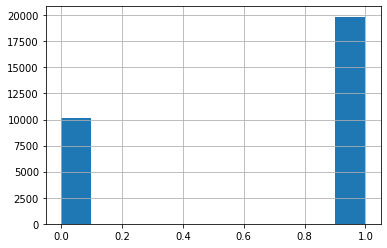

In [ ]:
pd.set_option('display.max_colwidth', -1)

# Remove empty review
df_data = df_data[['review', 'rating']].dropna()

# Convert target as integer
df_data['rating'] = df_data['rating'].astype('int')

# Create the new binary target
df_data['bin_rating'] = df_data['rating'].apply(lambda x: 1 if x > 3 else 0)

df_data["bin_rating"].hist()

In [ ]:
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    return df
    
def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df

def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

def remove_stop_words(df, colname):
    stop_words = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df

def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    return df


def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    3. Tokenize sentences
    4. Remove all stopwords
    5. convert tokenized text to text
    """
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df


# Define function to display loss and accuracy evolution during training
def plot_history(hist):
  plt.plot(hist.history['loss'], label='train')
  plt.plot(hist.history['val_loss'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Loss evolution')
  plt.show()
  plt.plot(hist.history['binary_accuracy'], label='train')
  plt.plot(hist.history['val_binary_accuracy'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Accuracy evolution')
  plt.show()


# define function to evaluate model performances
def model_evaluation(NN_model, x_test, y_test):
    
  y_pred_proba = NN_model.predict(x_test, verbose=1)
  y_pred = [1 if i >= 0.5 else 0 for i in y_pred_proba]
  print('accuracy {}'.format(round(accuracy_score(y_test, y_pred), 4)))
  print('f1 macro {}'.format(round(f1_score(y_test, y_pred, average='weighted'), 4)))

In [ ]:
df_cleaned = text_cleaning(df_data, 'review')

df_cleaned.sample(1)

,review,rating,bin_rating
17386,first complaining price wynn normally would spend 50 breakfast two vegas pretending wealthy staying hotel room 10 foot high ceilings square footage apartments la yes little pricey quality disappoint lobster eggs benedict 20 one eggs runny like solid lobster perfectly cooked fresh even got upsold 7 strawberry smoothie damn good even mind service attentive view great free wifi make place worth stop,4,1


In [ ]:
TARGET = 'bin_rating'
FEATURE = 'review'

x_train, x_test, y_train, y_test = train_test_split(
    df_cleaned[FEATURE], 
    df_cleaned[TARGET], 
    test_size=0.2,
    random_state=2019)

## **2. LSTM without pre-trained embedding**
### **2.1 Text vectorization**

LSTM https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
 # maximum number of words take into account by the model vocabulary
VOCAB_SIZE = 10000
# maximum number of words per text review
MAX_LENGTH = 100
# dimension of the embedding layer in the network
EMBEDDING_DIM = 200

In [ ]:
# tokenizer: transform sequence of word into sequence of index
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,.:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(x_train)

# vectorize train data
data_sequences_train = tokenizer.texts_to_sequences(x_train)
padded_data_sequences_train = pad_sequences(data_sequences_train, maxlen=MAX_LENGTH, padding='post', truncating='post')

# vectorize test data 
data_sequences_test = tokenizer.texts_to_sequences(x_test) 
padded_data_sequences_test = pad_sequences(data_sequences_test, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Set out-of index vocabulary to 0
padded_data_sequences_train[padded_data_sequences_train >= VOCAB_SIZE] = 0
padded_data_sequences_test[padded_data_sequences_test >= VOCAB_SIZE] = 0 

In [ ]:
x_train[0]

In [ ]:
padded_data_sequences_train[0]

array([  24,  173,   10,   58,   32, 2476,  354,   58,   98,  125,   14,
          3,  109,  361, 8762,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

### **2.2 Model training**

In [ ]:
def build_lstm_model(number_of_classes, vocab_size, max_length, embedding_dim):

    inp = Input(shape=(max_length, ))

    x = Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length,
                  trainable=True)(inp)

    x = Bidirectional(LSTM(128))(x)
    out = Dense(number_of_classes, activation='sigmoid', name='output')(x)

    model = Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(lr=0.005)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

    return model

In [ ]:
 # The model output is binary
MODEL_OUPUT_DIM = 1

lstm_model = build_lstm_model(
    MODEL_OUPUT_DIM, 
    VOCAB_SIZE, 
    MAX_LENGTH,
    EMBEDDING_DIM
)

In [ ]:
history = lstm_model.fit(
    padded_data_sequences_train,
    y_train.values,
    epochs=2,
    batch_size=1024,
    verbose=1,
    validation_split=0.1
    )

Train on 21595 samples, validate on 2400 samples
Epoch 1/2
21595/21595 [==============================] - 162s 7ms/sample - loss: 0.5450 - binary_accuracy: 0.7328 - val_loss: 0.5444 - val_binary_accuracy: 0.7613
Epoch 2/2
21595/21595 [==============================] - 154s 7ms/sample - loss: 0.3414 - binary_accuracy: 0.8587 - val_loss: 0.3557 - val_binary_accuracy: 0.8542


### **2.3 Model evaluation**

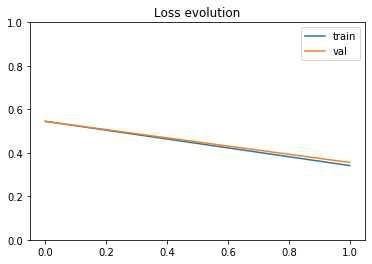

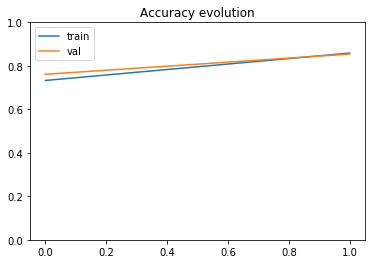

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
plot_history(history)
model_evaluation(NN_model=lstm_model, x_test=padded_data_sequences_test, y_test=y_test)

## **3. LSTM with pre-trained embedding**

### **3.1 fastText embedding**


![word2vec](https://pvsmt99345.i.lithium.com/t5/image/serverpage/image-id/45458iDEB69E518EBA3AD9/image-size/large?v=1.0&px=999)


*   fastText is a library developed by Facebook in 2016.
*   fastText is a word embedding method that is an extension of the word2vec model.
*   Word2vec (see graph above):

 - CBOW(Continuous Bag Of Words): Predict the target word using the input context words.
  - Skip-gram: Predict the context word using the input word.

*   Instead of learning vectors for words directly, fastText represents each word as an n-gram of characters.
*   This helps capture the meaning of shorter and rare words.









In [ ]:
# maximum number of words take into account by the model vocabulary
VOCAB_SIZE = 20000
# maximum number of words per text review
MAX_LENGTH = 150
# dimension of the embedding layer in the network
EMBEDDING_DIM = 200

In [ ]:
sentences_data = df_cleaned['review'].str.split(' ')

fastText_model = FastText(
    sentences_data,
    size=EMBEDDING_DIM,
    window=5,
    min_count=3,
    iter=10,
    min_n=3,
    max_n=6,
    workers=-1)

In [ ]:
fastText_model.most_similar('restaurant') 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('restaurants', 0.8394213914871216),
 ('nrestaurant', 0.8334202766418457),
 ('restauran', 0.8260542154312134),
 ('restaurante', 0.8207151889801025),
 ('restaurant/bar', 0.7507597208023071),
 ('bar/restaurant', 0.7146071195602417),
 ('restaurant/lounge', 0.6246247887611389),
 ('deli/restaurant', 0.6160355806350708),
 ('restraurant', 0.6016035079956055),
 ('resturant', 0.4851457476615906)]

In [ ]:
fastText_model.wv['restaurant']

array([-5.3505885e-04, -4.0218935e-04, -1.4116219e-04, -1.1834321e-03,
        4.5970693e-04, -6.7877874e-05,  3.6945054e-04,  5.8379705e-04,
       -6.1863271e-04, -4.9495982e-04, -1.2228861e-04, -6.5716496e-04,
       -4.2544593e-04,  7.4708660e-05, -2.5535854e-05, -2.1492997e-06,
        6.6773436e-04,  1.9926474e-04, -7.6620205e-04, -4.5566299e-04,
       -3.2909561e-04, -1.0682812e-03,  5.4365816e-04,  3.9074293e-04,
       -1.2278208e-04, -1.7044878e-04,  6.3570729e-04,  1.2616039e-04,
        2.3829780e-04, -1.2295344e-04, -2.2265523e-04, -2.8309907e-04,
        1.6534732e-04,  2.5700298e-04,  1.3505403e-04, -2.3560855e-05,
       -1.5549950e-04,  1.1400985e-04, -8.4428751e-04, -4.6293117e-06,
        3.2556010e-04, -6.9670263e-04,  3.1904419e-04,  6.7401759e-04,
        1.0290140e-03,  9.6051861e-04, -4.0985693e-04,  6.6761168e-05,
        2.6700131e-04, -2.1829585e-05,  1.2612151e-03, -8.4573234e-04,
        2.8811779e-04, -3.9401508e-04,  6.0348539e-04,  5.0800554e-05,
      

### **3.2 Initialize embedding matrix with fastText representation**

In [ ]:
def initialize_embedding_with_fastText(tokenizer, word_vectors, vocab_size, embedding_dim):
    """
    Build the embedding matrix with the fastText model to initilize the firt LSTM layer.
    """
    # word index
    word_index = tokenizer.word_index

    # define the number of word to keep (correspond to the input dimension of the model)
    nb_words = min(vocab_size, len(word_vectors.vocab)) + 1

    # initialize the matrix with random numbers
    wv_matrix = (np.random.rand(nb_words, embedding_dim) - 0.5) / 5.0

    # feed the matrix using fastText representation
    for word, i in word_index.items():
        if i >= nb_words:
            continue
        try:
            embedding_vector = word_vectors[word]
            # words not found in embedding index will be all-zeros.
            wv_matrix[i] = embedding_vector
        except:
            pass

    return wv_matrix, nb_words

In [ ]:
 # Initilaze embedding matrix with fastText vectorization
wv_matrix, input_size = initialize_embedding_with_fastText(
    tokenizer,
    fastText_model.wv,
    VOCAB_SIZE,
    EMBEDDING_DIM)

### **3.3 Text vectorization**

In [ ]:
# fit vectorizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,.:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(x_train)

# vectorize train data
data_sequences_train = tokenizer.texts_to_sequences(x_train)
padded_data_sequences_train = pad_sequences(data_sequences_train, maxlen=MAX_LENGTH, padding='post', truncating='post')

# vectorize test data
data_sequences_test = tokenizer.texts_to_sequences(x_test)
padded_data_sequences_test = pad_sequences(data_sequences_test, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Set out-of index vocabulary to 0
padded_data_sequences_train[padded_data_sequences_train >= input_size] = 0
padded_data_sequences_test[padded_data_sequences_test >= input_size] = 0

### **3.4 Model training** 

In [ ]:
def build_lstm_mode_with_fastText(number_of_classes, wv_matrix, VOCAB_SIZE, MAX_LENGTH, EMBEDDING_DIM):

    inp = Input(shape=(MAX_LENGTH, ))

    x = Embedding(input_dim=VOCAB_SIZE,
                  output_dim=EMBEDDING_DIM,
                  input_length=MAX_LENGTH,
                  weights=[wv_matrix],
                  trainable=False)(inp)

    x = Bidirectional(LSTM(128))(x)
    out = Dense(number_of_classes, activation='sigmoid', name='output')(x)

    model = Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(lr=0.005)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

    return model

In [ ]:
# The model output is binary
MODEL_OUPUT_DIM = 1

lstm_model_fastText = build_lstm_mode_with_fastText(
    MODEL_OUPUT_DIM,
    wv_matrix,
    input_size,
    MAX_LENGTH,
    EMBEDDING_DIM) 

In [ ]:
history = lstm_model_fastText.fit(
    padded_data_sequences_train,
    y_train.values,
    epochs=2,
    batch_size=1024,
    verbose=1,
    validation_split=0.1
)

Train on 21595 samples, validate on 2400 samples
Epoch 1/2
21595/21595 [==============================] - 105s 5ms/sample - loss: 0.4724 - binary_accuracy: 0.7726 - val_loss: 0.3317 - val_binary_accuracy: 0.8617
Epoch 2/2
21595/21595 [==============================] - 99s 5ms/sample - loss: 0.2454 - binary_accuracy: 0.9047 - val_loss: 0.3089 - val_binary_accuracy: 0.8717


### **3.5 Model evaluation**

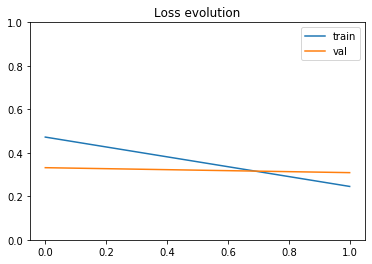

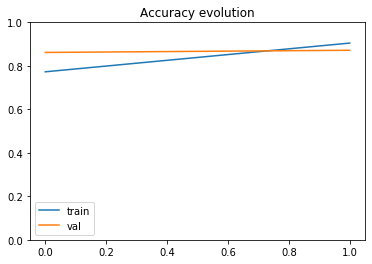

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
plot_history(history)
model_evaluation(NN_model=lstm_model_fastText, x_test=padded_data_sequences_test, y_test=y_test)


## **4. Exercice**
